## Import Library & Load Cleaned Data

In [1]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import scipy.sparse as sp
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import warnings; warnings.filterwarnings("ignore")

BASE_PATH = r"C:\Users\Irifoxet\Documents\Jupyter\Predict Movie\data"
PROCESSED_PATH = os.path.join(BASE_PATH, "processed")
CLEANED_PATH = os.path.join(PROCESSED_PATH, "cleaned")
PREPROCESS_PATH = os.path.join(PROCESSED_PATH, "preprocess")

EDA_PATH = os.path.join(PROCESSED_PATH, "eda")
os.makedirs(EDA_PATH, exist_ok=True)

def log(msg, lvl="INFO"): print(f"[{lvl}] {msg}")

files = {
    "movies": os.path.join(CLEANED_PATH, "movies_cleaned_f.csv"),
    "ratings": os.path.join(CLEANED_PATH, "ratings_cleaned_f.csv"),
    "tags": os.path.join(CLEANED_PATH, "tags_cleaned_f.csv"),
    "links": os.path.join(PROCESSED_PATH, "datasets", "links_cleaned.csv"),
    "tfidf": os.path.join(PREPROCESS_PATH, "movies_tfidf_features.csv"),
    "svd": os.path.join(PREPROCESS_PATH, "movies_tfidf_reduced.csv"),
    "hybrid": os.path.join(PREPROCESS_PATH, "hybrid_user_movie_info.csv"),
    "user_map": os.path.join(PREPROCESS_PATH, "user_mapping.csv"),
    "movie_map": os.path.join(PREPROCESS_PATH, "movie_mapping.csv"),
    "sparse": os.path.join(PREPROCESS_PATH, "user_movie_matrix_sparse.npz")
}

print("[RUN] Loading datasets in multiple locations...\n")
def load_csv(path, name):
    if os.path.exists(path):
        log(f"Loaded {name}")
        return pd.read_csv(path, low_memory=False)
    else:
        log(f"Missing {name}", "WARNING")
        return None

movies  = load_csv(files["movies"], "Movies")
ratings = load_csv(files["ratings"], "Ratings")
tags    = load_csv(files["tags"], "Tags")
links   = load_csv(files["links"], "Links")
tfidf   = load_csv(files["tfidf"], "TF-IDF Features")
svd     = load_csv(files["svd"], "SVD Reduced Features")
hybrid  = load_csv(files["hybrid"], "Hybrid Dataset")
user_map= load_csv(files["user_map"], "User Mapping")
movie_map=load_csv(files["movie_map"], "Movie Mapping")
    
print("\n[DONE] All files loaded successfully!")

[RUN] loading datasets in multiple locations...

[INFO] Loaded Movies
[INFO] Loaded Ratings
[INFO] Loaded Tags
[INFO] Loaded Links
[INFO] Loaded TF-IDF Features
[INFO] Loaded SVD Reduced Features
[INFO] Loaded Hybrid Dataset
[INFO] Loaded User Mapping
[INFO] Loaded Movie Mapping

[DONE] All files loaded successfully!


## Merge Core Data

In [2]:
print("[RUN] Merge datasets...\n")

movie_data = pd.merge(ratings, movies, on="movieId", how="left")
movie_data = pd.merge(movie_data, links, on="movieId", how="left")

movie_data["datetime"] = pd.to_datetime(movie_data["timestamp"], unit="s", errors="coerce")
movie_data["year_rated"] = movie_data["datetime"].dt.year
movie_data["month_rated"] = movie_data["datetime"].dt.month
movie_data["day_rated"] = movie_data["datetime"].dt.day

movie_data["year"] = pd.to_numeric(movie_data["year"], errors="coerce")
median_year = movie_data["year"].median()
movie_data["year"] = movie_data["year"].fillna(median_year)

movie_data["year_norm"] = MinMaxScaler().fit_transform(movie_data[["year"]])

log("Merged Ratings + Movies + Links with temporal features and cleaned 'year'")

[RUN] Merge datasets...

[INFO] Merged Ratings + Movies + Links with temporal features and cleaned 'year'


## Basic Structure Overview

In [3]:
for n,d in {"Movies":movies,"Ratings":ratings,"Tags":tags,"Hybrid":hybrid}.items():
    if d is not None:
        print(f"\n--- {n} ---")
        print("Shape:", d.shape)
        print("Columns:", list(d.columns)[:10])
        print(d.describe(include="all").T.head(5))


--- Movies ---
Shape: (87585, 23)
Columns: ['movieId', 'title', 'year', '(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime']
                      count unique         top  freq           mean  \
movieId             87585.0    NaN         NaN   NaN  157651.365519   
title                 87584  81136  Cinderella    19            NaN   
year                  87585    143      2017.0  3269            NaN   
(no genres listed)  87585.0    NaN         NaN   NaN       0.080836   
Action              87585.0    NaN         NaN   NaN       0.110384   

                             std  min       25%       50%       75%       max  
movieId             79013.402099  1.0  112657.0  165741.0  213203.0  292757.0  
title                        NaN  NaN       NaN       NaN       NaN       NaN  
year                         NaN  NaN       NaN       NaN       NaN       NaN  
(no genres listed)      0.272584  0.0       0.0       0.0       0.0       1.0  
Action     

## Rating Distribution

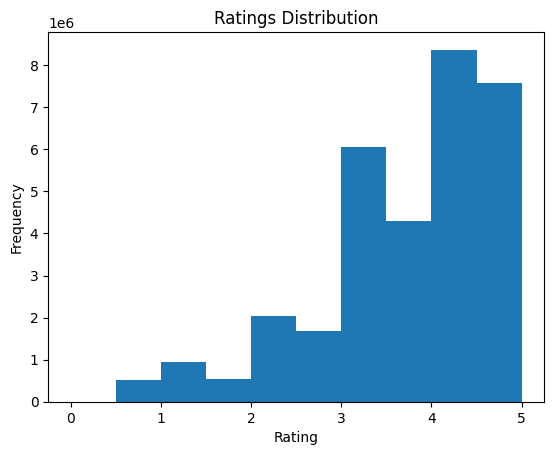

count    3.200020e+07
mean     3.540396e+00
std      1.058986e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


In [4]:
plt.hist(ratings["rating"], bins=np.arange(0,5.5,0.5))
plt.title("Ratings Distribution"); plt.xlabel("Rating"); plt.ylabel("Frequency"); plt.show()
print(ratings["rating"].describe())

## User & Movie Activity

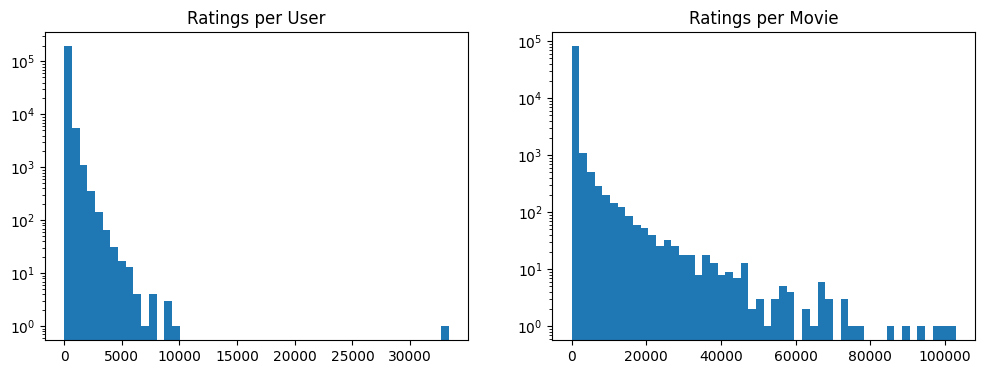

Users: 200948 | Movies: 84432


In [5]:
user_activity = ratings.groupby("userId").size()
movie_activity = ratings.groupby("movieId").size()
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].hist(user_activity, bins=50); ax[0].set_title("Ratings per User"); ax[0].set_yscale("log")
ax[1].hist(movie_activity, bins=50); ax[1].set_title("Ratings per Movie"); ax[1].set_yscale("log")
plt.show()
print("Users:", len(user_activity), "| Movies:", len(movie_activity))

## Popularity vs Average Rating

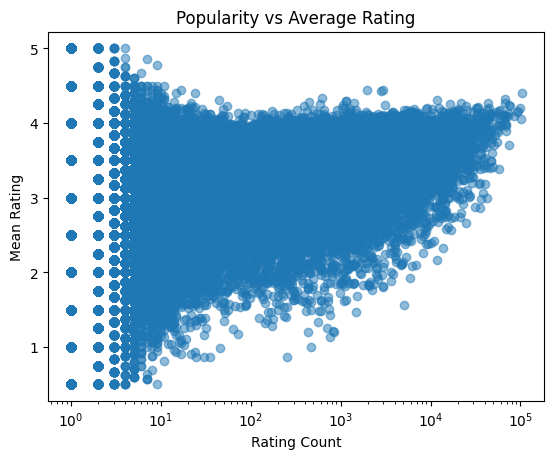

In [6]:
stats = ratings.groupby("movieId")["rating"].agg(["count","mean"]).reset_index()
stats = stats.merge(movies[["movieId","title"]], on="movieId", how="left")
plt.scatter(stats["count"], stats["mean"], alpha=0.5)
plt.xscale("log"); plt.title("Popularity vs Average Rating"); plt.xlabel("Rating Count"); plt.ylabel("Mean Rating")
plt.show()

## Top Movies

In [7]:
top_popular = stats.sort_values("count", ascending=False).head(15)
top_best = stats[stats["count"]>=50].sort_values("mean", ascending=False).head(15)
print("Top Popular Movies:"); display(top_popular[["title","count","mean"]])
print("Top Rated Movies:"); display(top_best[["title","count","mean"]])

Top Popular Movies:


,title,count,mean
314,"Shawshank Redemption, The",102929,4.404614
351,Forrest Gump,100296,4.052744
292,Pulp Fiction,98409,4.196969
2480,"Matrix, The",93808,4.156437
585,"Silence of the Lambs, The",90330,4.148367
257,Star Wars: Episode IV - A New Hope,85010,4.099824
2867,Fight Club,77332,4.228780
475,Jurassic Park,75233,3.698623
522,Schindler's List,73849,4.236990
4888,"Lord of the Rings: The Fellowship of the Ring,...",73122,4.092134


Top Rated Movies:


,title,count,mean
44190,Planet Earth II,1956,4.446830
39306,Planet Earth,2948,4.444369
44042,Band of Brothers,2811,4.426539
314,"Shawshank Redemption, The",102929,4.404614
44416,Cosmos,615,4.330081
840,"Godfather, The",66440,4.317030
58698,Parasite,11670,4.312254
47975,Blue Planet II,1163,4.300086
56760,Twin Peaks,1140,4.298684
65936,Twelve Angry Men,449,4.286192


## Genre Insight

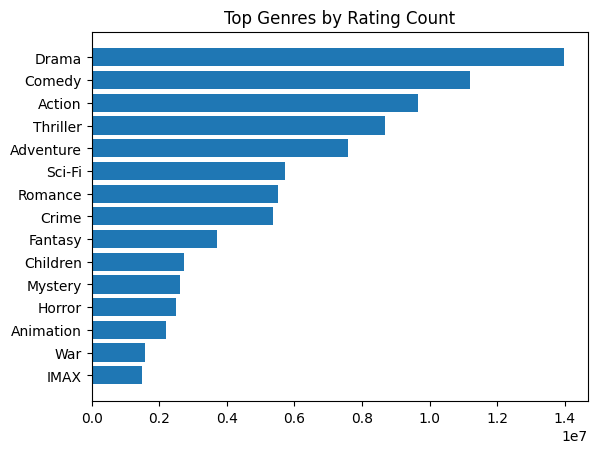

In [8]:
genre_cols = [c for c in movies.columns if c not in ["movieId","title","year"]]
merged_g = ratings.merge(movies[["movieId"]+genre_cols], on="movieId")
genre_stats = {g:{"count":(merged_g[g]==1).sum(),"avg":merged_g.loc[merged_g[g]==1,"rating"].mean()} for g in genre_cols}
genre_df = pd.DataFrame(genre_stats).T.sort_values("count", ascending=False)
plt.barh(genre_df.index[:15][::-1], genre_df["count"][:15][::-1])
plt.title("Top Genres by Rating Count"); plt.show()

## Yearly Trend

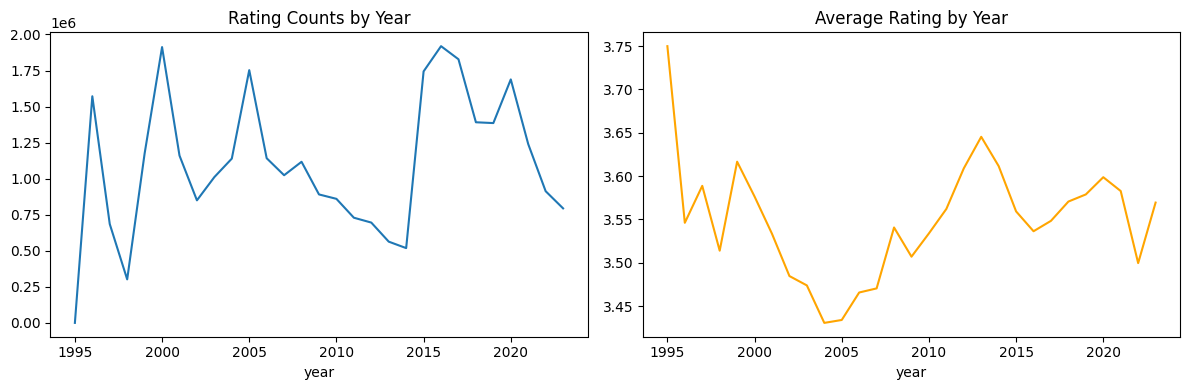

In [9]:
trend = ratings.copy()
trend["datetime"] = pd.to_datetime(trend["timestamp"], unit="s")
trend["year"] = trend["datetime"].dt.year
agg = trend.groupby("year")["rating"].agg(["count","mean"]).dropna()
fig, ax = plt.subplots(1,2,figsize=(12,4))
agg["count"].plot(ax=ax[0], title="Rating Counts by Year")
agg["mean"].plot(ax=ax[1], title="Average Rating by Year", color="orange")
plt.tight_layout(); plt.show()

## User Bias

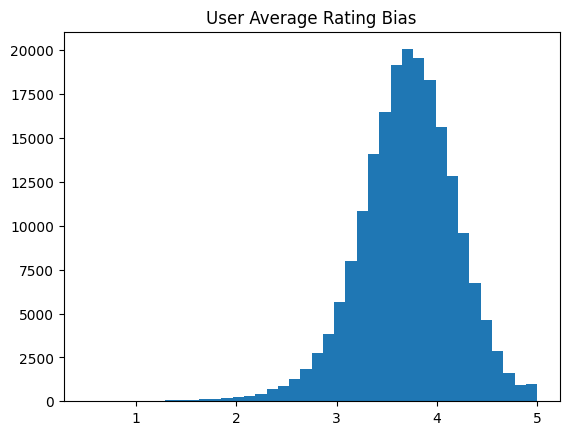

Mean bias range: 0.5 - 5.0


In [10]:
user_bias = ratings.groupby("userId")["rating"].mean()
plt.hist(user_bias, bins=40); plt.title("User Average Rating Bias"); plt.show()
print("Mean bias range:", user_bias.min(), "-", user_bias.max())

## Tag Analysis

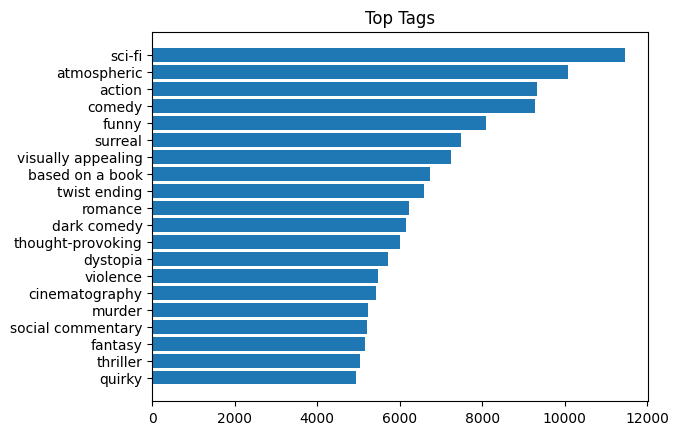

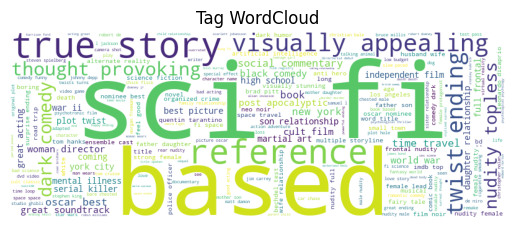

In [11]:
tags["tag_clean"] = tags["tag"].astype(str).str.lower().str.strip()
top_tags = tags["tag_clean"].value_counts().head(20)
plt.barh(top_tags.index[::-1], top_tags.values[::-1]); plt.title("Top Tags"); plt.show()
wc = WordCloud(width=800,height=300,background_color="white").generate(" ".join(tags["tag_clean"]))
plt.imshow(wc); plt.axis("off"); plt.title("Tag WordCloud"); plt.show()

## Sparse Matrix Stats

In [12]:
sp_path = files["sparse"]
if os.path.exists(sp_path):
    mat = sp.load_npz(sp_path)
    print("Shape:", mat.shape, "| Nonzeros:", mat.nnz)
    sparsity = 1 - mat.nnz / np.prod(mat.shape)
    print(f"Sparsity = {sparsity:.4%}")

Shape: (200948, 84432) | Nonzeros: 32000204
Sparsity = 99.8114%


## TF-IDF Similarity

In [13]:
if svd is not None:
    features = svd.drop(columns=["movieId"], errors="ignore").values
    ids = svd.get("movieId", movies["movieId"].head(len(features)))
    sims = cosine_similarity(features[0:1], features).flatten()
    similar_idx = sims.argsort()[::-1][1:6]
    base_title = movies[movies["movieId"]==ids.iloc[0]]["title"].values[0]
    print("Similar to:", base_title)
    for i in similar_idx:
        title = movies[movies["movieId"]==ids.iloc[i]]["title"].values[0]
        print(" → ", title)

Similar to: Toy Story
 →  Toy Story 2
 →  Finding Dory
 →  Bolt
 →  Bug's Life, A
 →  Finding Nemo


## Correlation (Hybrid Numeric Features)

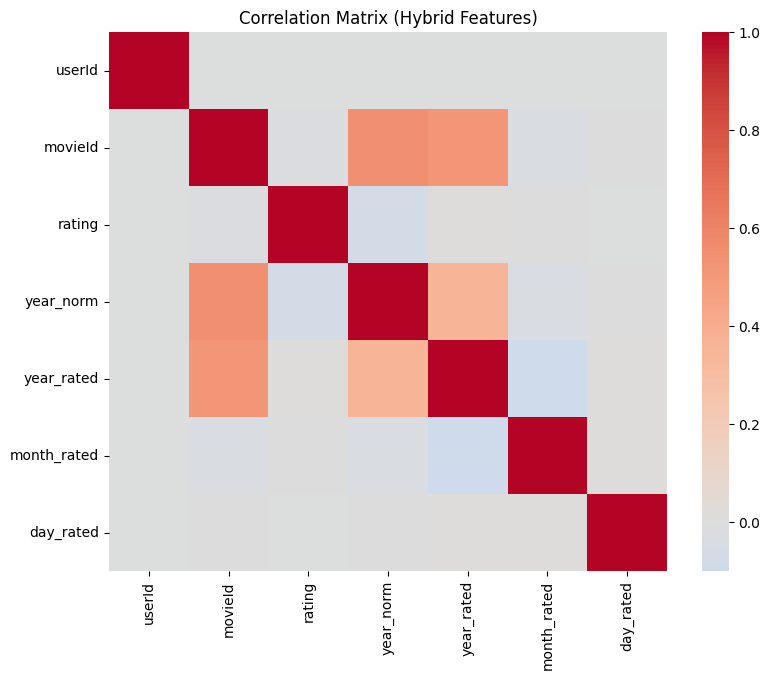

In [14]:
if hybrid is not None:
    num = hybrid.select_dtypes(include=[np.number])
    corr = num.corr()
    plt.figure(figsize=(9,7))
    sns.heatmap(corr, cmap="coolwarm", center=0)
    plt.title("Correlation Matrix (Hybrid Features)")
    plt.show()

## Temporal & Genre Interaction

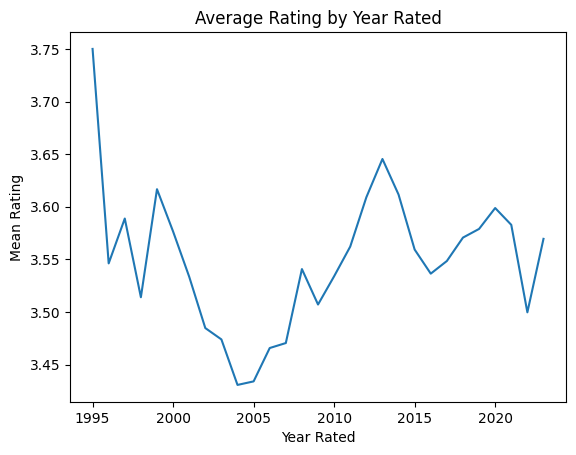

In [15]:
tmp = movie_data.groupby(["year_rated"])["rating"].mean()
plt.plot(tmp.index, tmp.values)
plt.title("Average Rating by Year Rated"); plt.xlabel("Year Rated"); plt.ylabel("Mean Rating"); plt.show()

## Combined Outlier Analysis

In [16]:
z = np.abs((ratings["rating"]-ratings["rating"].mean())/ratings["rating"].std())
outliers = ratings[z>2]
print("Potential outlier ratings count:", len(outliers))

Potential outlier ratings count: 1471807


## Export Summary

In [17]:
stats.to_csv(os.path.join(EDA_PATH,"movie_stats.csv"), index=False)
genre_df.to_csv(os.path.join(EDA_PATH,"genre_stats.csv"))
agg.to_csv(os.path.join(EDA_PATH,"rating_trends.csv"))
log("Exported EDA summaries to /data/processed/eda", "DONE")

[DONE] Exported EDA summaries to /data/processed/eda
